Libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
import random
from collections import Counter

import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# Pandas setting
pd.set_option('display.max_columns', 50)

np.set_printoptions(threshold=20)

### **1. Business Understanding & Objective**

Assumption:
- Tesloh is a new emerging automotive company
- Tesloh is aiming to release a new car in 2025, they want gather preferences on various car features/attributes (including price)
- The company will use these information for considerations in developing their new car product.
- The company will use conjoint analysis to analyze car sales data from 2015-2020 

**1.2 Business Objective**

- What car attributes are important for customers?
- What is the optimal price should the company set to attract customers?

**1.3 Modelling Task**

- Output target: customer choice
- The goal of this project is model customer choice (Choice Based Conjoint Method / CBC)
- Modelling task: Classification
- We need interpretable model, so model used: Logistic Regression
- Our target response is imbalance, so we consider use f1-score as evaluation metric

### **2. Read Data**

In [2]:
# read dataset function
def read_data(path):
    """
    Reads a CSV file at the given path
    and returns its contents as a pandas DataFrame.

    Parameters
    ----------
    path : str
        input path

    Returns
    -------
    df : pandas Dataframe
        Sample dataframe
    """
    # Read data
    data = pd.read_csv(path)
    print('Original data shape :', data.shape)

    return data

In [3]:
# Read data
df_raw = read_data(path = 'car_price_prediction.csv')
df_raw

Original data shape : (19237, 18)


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,45798355,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
19233,45778856,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,8
19234,45804997,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
19235,45793526,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258 km,4.0,Automatic,Front,04-May,Left wheel,Black,4


#### **2.1. Check missing values and duplicate data**

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [5]:
# check missing values, sorted from highest 
print("Missing values proportion:")
print(df_raw.isna().sum().sort_values(ascending = False)/df_raw.shape[0]*100)

# Check duplicates
print("="*50)
print(f'Duplicate data: {df_raw.duplicated().any()}')

Missing values proportion:
ID                  0.0
Price               0.0
Color               0.0
Wheel               0.0
Doors               0.0
Drive wheels        0.0
Gear box type       0.0
Cylinders           0.0
Mileage             0.0
Engine volume       0.0
Fuel type           0.0
Leather interior    0.0
Category            0.0
Prod. year          0.0
Model               0.0
Manufacturer        0.0
Levy                0.0
Airbags             0.0
dtype: float64
Duplicate data: True


No missing values but there are duplicated data.

In [6]:
# Drop duplicate
df_raw = df_raw.drop_duplicates(keep='first')
print(f'Duplicate data: {df_raw.duplicated().any()}')

Duplicate data: False


#### **2.2. Drop unnecessary columns**

In [7]:
df_dropped = df_raw.copy()
df_dropped.drop(columns=['Manufacturer', 'Model', 'Levy', 'Mileage', 'Doors','Engine volume', 'Airbags'], inplace=True)

df_dropped.head()

,ID,Price,Prod. year,Category,Leather interior,Fuel type,Cylinders,Gear box type,Drive wheels,Wheel,Color
0,45654403,13328,2010,Jeep,Yes,Hybrid,6.0,Automatic,4x4,Left wheel,Silver
1,44731507,16621,2011,Jeep,No,Petrol,6.0,Tiptronic,4x4,Left wheel,Black
2,45774419,8467,2006,Hatchback,No,Petrol,4.0,Variator,Front,Right-hand drive,Black
3,45769185,3607,2011,Jeep,Yes,Hybrid,4.0,Automatic,4x4,Left wheel,White
4,45809263,11726,2014,Hatchback,Yes,Petrol,4.0,Automatic,Front,Left wheel,Silver


#### **2.3. Filter the data**

In [8]:
df_dropped["Prod. year"].describe()

count    18924.000000
mean      2010.914236
std          5.665749
min       1939.000000
25%       2009.000000
50%       2012.000000
75%       2015.000000
max       2020.000000
Name: Prod. year, dtype: float64

- The dataset has data of cars produced from 1939 to 2020
- Old cars data might not be relevant in modern times
- We will filter the dataset to get the last 5 years of data (2015-2020)

In [9]:
year_filter = [2015,2016,2017,2018,2019,2020]
df_filtered = df_dropped[df_dropped['Prod. year'].isin(year_filter)]

df_filtered['Prod. year'].describe()


count    4759.000000
mean     2016.314352
std         1.251290
min      2015.000000
25%      2015.000000
50%      2016.000000
75%      2017.000000
max      2020.000000
Name: Prod. year, dtype: float64

In [10]:
df_filtered.head()

,ID,Price,Prod. year,Category,Leather interior,Fuel type,Cylinders,Gear box type,Drive wheels,Wheel,Color
5,45802912,39493,2016,Jeep,Yes,Diesel,4.0,Automatic,Front,Left wheel,White
14,45732604,59464,2016,Jeep,Yes,Diesel,4.0,Automatic,Front,Left wheel,White
15,45465200,549,2018,Jeep,Yes,Petrol,4.0,Automatic,Front,Left wheel,White
16,45772281,7683,2016,Sedan,Yes,Petrol,4.0,Automatic,Front,Left wheel,Blue
17,45797221,28382,2016,Sedan,Yes,Petrol,4.0,Automatic,Front,Left wheel,White


In [11]:
df_filtered['Cylinders'].value_counts()

4.0     4048
6.0      461
8.0      204
3.0       23
12.0      10
5.0        7
1.0        4
16.0       1
2.0        1
Name: Cylinders, dtype: int64

- Because above 6 cylinders are considered trucks, we will filter the 4-6 cylinders only

In [12]:
cylinder_filter = [4, 6]
df_filtered = df_filtered[df_filtered['Cylinders'].isin(cylinder_filter)]

df_filtered['Cylinders'].describe()

count    4509.000000
mean        4.204480
std         0.605994
min         4.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         6.000000
Name: Cylinders, dtype: float64

In [13]:
df_filtered['Category'].value_counts()

Sedan          2327
Jeep           1539
Hatchback       349
Universal       130
Coupe            73
Minivan          70
Pickup           10
Cabriolet         6
Microbus          4
Goods wagon       1
Name: Category, dtype: int64

In [14]:
df_filtered['Leather interior'].value_counts()

Yes    3904
No      605
Name: Leather interior, dtype: int64

In [15]:
df_filtered['Fuel type'].value_counts()

Petrol            2560
Diesel             937
Hybrid             551
LPG                443
Plug-in Hybrid      18
Name: Fuel type, dtype: int64

In [16]:
df_filtered['Drive wheels'].value_counts()

Front    3621
4x4       634
Rear      254
Name: Drive wheels, dtype: int64

In [17]:
df_filtered['Price'].describe()

count      4509.000000
mean      26023.187403
std       23938.600177
min           3.000000
25%        8781.000000
50%       20385.000000
75%       39615.000000
max      308906.000000
Name: Price, dtype: float64

In [18]:
df_sedan = df_filtered[(df_filtered['Category'] == 'Sedan')]
df_sedan['Price'].describe()

count      2327.000000
mean      18785.664804
std       17725.665911
min           3.000000
25%        5018.000000
50%       15681.000000
75%       24462.000000
max      132971.000000
Name: Price, dtype: float64

- Because the median price of Sedan is around $15000 dollars, we will make price options with 5k difference 
- The price options will be 15-20-25

### **3. Generate Combinations**

- Company conduct conjoint analysis with 8 pairs of attribute
- Company determine the survey design with only 20 questions
- Each of question will have 3 options with 1 additional None option
- It means we need to generate 60 combinations (3 * 20)

In [19]:
# Set the choices for each attribute

attribute_1 = ['Leather', 'Non-leather'] # Leather interior?
attribute_2 = ['Petrol', 'Diesel', 'Hybrid'] # Fuel Type
attribute_3 = [4, 6] # Cylinders
attribute_4 = ['Front', '4x4', 'Rear'] #Drive wheels
attribute_5 = [15, 20, 25] # Price

all_attributes = [attribute_1, attribute_2, attribute_3, attribute_4, attribute_5]

# 1. Generate all possible combinations of attributes and prices
combinations = list(itertools.product(*all_attributes))

# 2. Shuffle the combinations to add randomness
random.seed(42)
random.shuffle(combinations)

# 3. Create 60 random pairs with approximately equal frequency
# pairs = combinations[:60]

# 4. Create a DataFrame with the pairs
#df_pairs = pd.DataFrame(pairs, columns=['Leather interior', 'Fuel type', 'Cylinders', 'Drive wheels'])

# Make the combinations and store to list
combi_list = []
for combi in combinations:
    combi_list.append(combi)



In [20]:
# Make into dataframe
df_combi_raw = pd.DataFrame(combi_list, columns=['Leather interior', 'Fuel type', 'Cylinders', 'Drive wheels', 'Price'])
df_combi_raw

,Leather interior,Fuel type,Cylinders,Drive wheels,Price
0,Non-leather,Petrol,4,4x4,25
1,Leather,Petrol,6,Front,15
2,Leather,Petrol,4,Front,20
3,Non-leather,Petrol,6,Front,25
4,Non-leather,Hybrid,6,4x4,15
...,...,...,...,...,...
103,Leather,Diesel,6,Rear,25
104,Non-leather,Hybrid,4,4x4,20
105,Leather,Petrol,4,4x4,15
106,Leather,Petrol,6,4x4,25


In [21]:
# Break down attribute column values
a = np.char.array(df_combi_raw['Leather interior'].values)
b = np.char.array(df_combi_raw['Fuel type'].values)
c = np.char.array(df_combi_raw['Cylinders'].values)
d = np.char.array(df_combi_raw['Drive wheels'].values)

# Merge attributes to a single colum
df_combi_raw['Feature'] = (a + b', ' + b + b', ' + c + b', ' + d).astype(str)


In [22]:
# Sanity check
df_combi_raw = df_combi_raw[['Feature', 'Price']]
df_combi_raw

,Feature,Price
0,"Non-leather, Petrol, 4, 4x4",25
1,"Leather, Petrol, 6, Front",15
2,"Leather, Petrol, 4, Front",20
3,"Non-leather, Petrol, 6, Front",25
4,"Non-leather, Hybrid, 6, 4x4",15
...,...,...
103,"Leather, Diesel, 6, Rear",25
104,"Non-leather, Hybrid, 4, 4x4",20
105,"Leather, Petrol, 4, 4x4",15
106,"Leather, Petrol, 6, 4x4",25


In [23]:
df_combi = df_combi_raw[:90]

# Check the distribution of the prices
df_combi['Price'].value_counts()

20    31
25    30
15    29
Name: Price, dtype: int64

- Using random seed(42), we have 31-30-29 distribution for the prices
- The difference not too high, so we'll go with this one

Generate question variants for the survey

In [24]:
def generateVariant(combi_data, n_question):
    """
    Function to generate variant
    Parameters
    ----------

    combi_data: pandas Dataframe
        Conjoint Attribute dataframe

    n_question: int
        number of question in conjoint survey

    Returns
    -------
    varian: dict
        Question variant
    """
    # Extract combi data
    total_combi, n_attribute = combi_data.shape
    n_combi = int(total_combi/n_question)

    # separate combi_data to chunk per question
    combi_chunks = [combi_data[i:i+n_combi] for i in range(0, total_combi, n_combi)]

    # Extract variant
    options = "ABCD"
    varian = {}

    for no, chunk in enumerate(combi_chunks):
        # reset index chunk
        chunk = chunk.reset_index(drop = True)

        # extract every combination in each question
        question_dict = {}
        for i in range(n_combi):
            question_dict[options[i]] = chunk.loc[i].tolist()

        question_dict["D"] = ["" for i in range(n_attribute)]

        # add question_dict to varian
        varian[no+1] = question_dict

    return varian

In [25]:
VARIAN = generateVariant(combi_data = df_combi,
                         n_question = 30)

VARIAN

{1: {'A': ['Non-leather, Petrol, 4, 4x4', 25],
  'B': ['Leather, Petrol, 6, Front', 15],
  'C': ['Leather, Petrol, 4, Front', 20],
  'D': ['', '']},
 2: {'A': ['Non-leather, Petrol, 6, Front', 25],
  'B': ['Non-leather, Hybrid, 6, 4x4', 15],
  'C': ['Leather, Petrol, 6, Rear', 15],
  'D': ['', '']},
 3: {'A': ['Non-leather, Petrol, 4, Rear', 25],
  'B': ['Non-leather, Petrol, 6, 4x4', 20],
  'C': ['Non-leather, Diesel, 6, 4x4', 20],
  'D': ['', '']},
 4: {'A': ['Leather, Diesel, 4, Rear', 25],
  'B': ['Non-leather, Diesel, 6, 4x4', 15],
  'C': ['Non-leather, Hybrid, 6, Rear', 25],
  'D': ['', '']},
 5: {'A': ['Leather, Diesel, 6, 4x4', 15],
  'B': ['Leather, Diesel, 6, 4x4', 25],
  'C': ['Non-leather, Petrol, 6, 4x4', 25],
  'D': ['', '']},
 6: {'A': ['Leather, Hybrid, 4, Rear', 25],
  'B': ['Non-leather, Petrol, 4, Rear', 15],
  'C': ['Non-leather, Diesel, 6, Front', 20],
  'D': ['', '']},
 7: {'A': ['Non-leather, Diesel, 4, Rear', 25],
  'B': ['Leather, Hybrid, 6, 4x4', 25],
  'C': [

### **4. Validate Combinations**

In [26]:
def check_attribute(df_pairs, df_attribute):
    """
    Check if the columns of a DataFrame 'df_pairs' have the same unique values
    as the corresponding columns in another DataFrame 'df_attribute'.

    Parameters
    ----------
    df_pairs : pandas DataFrame
        A DataFrame containing pairs of attributes and the corresponding prices.

    df_attribute : pandas DataFrame
        A DataFrame containing a list of unique attributes and prices.

    Returns
    -------
    result : bool
        True if the unique values of columns in 'df_pairs' are the same as those
        in 'df_attribute' for all columns, False otherwise.
    """
    # Get the column names of the DataFrame df_pairs
    cols = df_pairs.columns

    # Loop through each column of df_pairs
    for col in cols:
      if set(df_pairs[col]) == set(df_attribute[col]):
        return True
      else:
        return False

In [27]:
# check attribute
check_attribute(df_combi, df_combi_raw)

True

- All attributes in the original filtered data appears in each question equally


In [28]:
def check_distribution(df_pairs, threshold=1):
    """
    Check if the distribution of unique values in the columns of a DataFrame 'df_pairs' is within a specified threshold.

    Parameters
    ----------
    df_pairs : pandas DataFrame
        A DataFrame containing pairs of attributes and their corresponding prices.

    threshold : int
        The threshold value for the range of occurrence counts of unique values.
        The default value is 1.

    Returns
    -------
    results : list of bool
        A list of boolean values where each element corresponds to a column in 'df_pairs'.
    """
    # Get the column names of the DataFrame df_pairs
    cols = df_pairs.columns

    # Initialize an empty list to store results for each column
    results = []

    # Loop through each column of df_pairs
    for col in cols:
        # Get the unique values and their occurrence counts in the current column
        values, counts = np.unique(df_pairs[col], return_counts=True)
        # Calculate the range of occurrence counts (difference between max and min counts)
        range = np.max(counts) - np.min(counts)
        # Append the result (True or False) to the results list
        results.append(range <= threshold)

    return results


In [29]:
# check distribution
check_distribution(df_combi, threshold=2)

[True, True]

### **5. Questionnaire**

##### **5.1. Wrangling the Questionnaire**

In [31]:
for x in range(1,31):
    print(f"{x}" + ",")

1,
2,
3,
4,
5,
6,
7,
8,
9,
10,
11,
12,
13,
14,
15,
16,
17,
18,
19,
20,
21,
22,
23,
24,
25,
26,
27,
28,
29,
30,


In [32]:
# Create empty dataframe for survey

df_survey = pd.DataFrame(columns=['Gender',1,
2,
3,
4,
5,
6,
7,
8,
9,
10,
11,
12,
13,
14,
15,
16,
17,
18,
19,
20,
21,
22,
23,
24,
25,
26,
27,
28,
29,
30], index=range(50))
df_survey.head()

,Gender,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Fill the dataframe with random choices from a possible list of answers.
gender = ["Male","Female"]
answer = ["A","B","C","A, B","A,C","B, C", "D. None (No choice)"]

np.random.seed(41)
df_survey['Gender'] = np.random.choice(list(gender), len(df_survey))

for question in range(1,31):
    df_survey[question] = np.random.choice(list(answer), len(df_survey))
    
df_survey.head()

,Gender,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,Male,C,"B, C",A,A,"B, C",C,B,C,A,"A,C",C,"A, B","B, C","B, C","A, B","A,C","A, B","A,C",D. None (No choice),"B, C",C,"A,C","A, B",C,C,"A, B",D. None (No choice),"B, C",C,"A, B"
1,Female,"A, B",C,"A,C",C,"A,C",C,"B, C",D. None (No choice),"B, C",C,"A, B",A,"A, B",B,C,"A, B",C,"B, C",D. None (No choice),"A, B",C,D. None (No choice),"A, B","A,C",D. None (No choice),"A, B",D. None (No choice),"B, C",D. None (No choice),"A, B"
2,Male,"A,C",C,B,"B, C",B,D. None (No choice),"A,C","A,C","A, B",D. None (No choice),"A,C","B, C",A,D. None (No choice),C,"A,C","A,C",A,B,C,"A, B",B,C,D. None (No choice),D. None (No choice),A,A,"A, B",A,D. None (No choice)
3,Male,"B, C",A,"B, C",C,"A, B","A, B","B, C","B, C","B, C","A,C",B,A,D. None (No choice),A,D. None (No choice),"A, B","B, C",D. None (No choice),"B, C",A,A,D. None (No choice),"A, B",A,"B, C","A,C","A,C","A, B","A, B",D. None (No choice)
4,Male,"A,C",B,"A,C",B,C,"B, C",A,A,D. None (No choice),B,B,D. None (No choice),"A,C",B,C,"B, C","A, B",B,"A,C","A, B",B,"A,C","B, C","A, B",C,"A,C",C,"B, C",D. None (No choice),A


In [34]:
# check
df_survey['Gender'].value_counts()

Male      26
Female    24
Name: Gender, dtype: int64

##### **5.2. Generate Conjoint Data**

In [35]:
OPTIONS = "ABC"

In [36]:
def get_user_answer_raw(user_data):
    """
    Function to get user answer (dirty data)

    Parameters
    ----------

    user_data: pandas Series
        sampel user

    Returns
    -------

    user_answer_list: list
      user list answer
    """
    # Define
    user_answer_list = []
    n = len(user_data.index)

    for i in range(n):
        if i>0 and i<n-1:
            user_answer_list.append(user_data[i])

    return user_answer_list

def edit_answer(answer):
    """
    Function to edit the answer

    Parameters
    ----------

    answer: list
        raw answer

    Returns
    -------

    edited_answer: list
        edited answer
    """
    edited_answer = str(answer).replace(". None (No choice)", "")
    edited_answer = edited_answer.replace(" ", "")
    edited_answer = edited_answer.split(",")

    return edited_answer

def get_ohe_answer(answer):
    """
    Function to encode (OHE) the answer
    e.g.,:
    input: ["A"],       output: [1, 0, 0]
    input: ["A", "C"],  output: [1, 0, 1]
    input: ["D"],       output: [0, 0, 0]

    Parameters
    ----------

    answer: list
      answer list

    Returns
    -------

    ohe_answer: list
        OHE answer
    """
    ohe_answer = [1 if opt in answer else 0 for opt in OPTIONS]

    return ohe_answer

def convert_user_answer(user_answer_list):
    """
    Function to convert user answer from choice to feature

    Parameters
    ----------

    user_answer_list: list
        user answer choice

    Returns
    -------

    converted_user_answer_list: list
        choosen feature by user
    """
    converted_user_answer_list = []

    for idx, answer in enumerate(user_answer_list):
        # Edit answer
        answer = edit_answer(answer = answer)

        # Get ohe answer
        ohe_answer = get_ohe_answer(answer = answer)

        # Convert ohe answer
        for i in range(len(OPTIONS)):
            converted_answer = VARIAN[idx+1][OPTIONS[i]].copy()
            converted_answer.insert(0, ohe_answer[i])
            converted_user_answer_list.append(converted_answer)

    return converted_user_answer_list

def convert_answer_to_df(user_data, user_answer):
    """
    Function to convert user answer to dataframe

    Parameters
    ----------

    user_data: pandas Series
        sampel user

    user_answer: list
        User answer

    Returns
    -------

    user_answer_df: pandas Dataframe
        user answer
    """
    user_answer = np.array(user_answer)

    user_answer_df = pd.DataFrame({"Choice": user_answer[:, 0],
                                   "Attribute": user_answer[:, 1],
                                   "Price": user_answer[:, 2]})

    user_answer_df["Gender"] = user_data["Gender"]


    user_answer_df = user_answer_df[["Gender",
                                     "Choice", "Price","Attribute"]]

    return user_answer_df

def get_user_answer_clean(user_data):
    """
    Function to get clean user answer

    Parameters
    ----------

    user_data: pandas Series
        sampel user

    Returns
    -------

    clean_user_answer: pandas dataframe
        user answer
    """
    # get raw user answer
    raw_user_answer_list = get_user_answer_raw(user_data = user_data)

    # clean raw user answer
    clean_user_answer_list = convert_user_answer(user_answer_list = raw_user_answer_list)

    # convert answer to pandas dataframe
    clean_user_answer = convert_answer_to_df(user_data = user_data,
                                             user_answer = clean_user_answer_list)

    return clean_user_answer

def generate_conjoint_data(raw_data):
    """
    Function to generate conjoint data

    Parameters
    ----------

    raw_data: pandas Dataframe
        sampel data raw

    Returns
    -------

    conjoint_data: pandas Dataframe
        sampel data final
    """
    conjoint_data = pd.DataFrame()

    for user in raw_data.index:
        # Get user data
        user_data = raw_data.loc[user]

        # Get clean user answer
        clean_user_answer = get_user_answer_clean(user_data = user_data)

        # Concat data
        conjoint_data = pd.concat([conjoint_data, clean_user_answer])

    return conjoint_data

In [37]:
# Check conjoint data
conjoint_data = generate_conjoint_data(raw_data = df_survey)
conjoint_data

,Gender,Choice,Price,Attribute
0,Male,0,25,"Non-leather, Petrol, 4, 4x4"
1,Male,0,15,"Leather, Petrol, 6, Front"
2,Male,1,20,"Leather, Petrol, 4, Front"
3,Male,0,25,"Non-leather, Petrol, 6, Front"
4,Male,1,15,"Non-leather, Hybrid, 6, 4x4"
...,...,...,...,...
82,Male,0,20,"Leather, Diesel, 4, Rear"
83,Male,0,25,"Non-leather, Petrol, 6, Rear"
84,Male,0,15,"Non-leather, Hybrid, 4, Front"
85,Male,0,25,"Non-leather, Diesel, 4, 4x4"


In [38]:
# Break down the the attributes to each of their respective column. 
conjoint_data[['Leather', 'Fuel Type', 'Cylinders', 'Drive wheel']] = conjoint_data["Attribute"].str.split(',', expand=True)
conjoint_data["Choice"] = conjoint_data['Choice'].astype('int64')
conjoint_data


,Gender,Choice,Price,Attribute,Leather,Fuel Type,Cylinders,Drive wheel
0,Male,0,25,"Non-leather, Petrol, 4, 4x4",Non-leather,Petrol,4,4x4
1,Male,0,15,"Leather, Petrol, 6, Front",Leather,Petrol,6,Front
2,Male,1,20,"Leather, Petrol, 4, Front",Leather,Petrol,4,Front
3,Male,0,25,"Non-leather, Petrol, 6, Front",Non-leather,Petrol,6,Front
4,Male,1,15,"Non-leather, Hybrid, 6, 4x4",Non-leather,Hybrid,6,4x4
...,...,...,...,...,...,...,...,...
82,Male,0,20,"Leather, Diesel, 4, Rear",Leather,Diesel,4,Rear
83,Male,0,25,"Non-leather, Petrol, 6, Rear",Non-leather,Petrol,6,Rear
84,Male,0,15,"Non-leather, Hybrid, 4, Front",Non-leather,Hybrid,4,Front
85,Male,0,25,"Non-leather, Diesel, 4, 4x4",Non-leather,Diesel,4,4x4


In [39]:
conjoint_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4350 entries, 0 to 86
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Gender       4350 non-null   object
 1   Choice       4350 non-null   int64 
 2   Price        4350 non-null   object
 3   Attribute    4350 non-null   object
 4   Leather      4350 non-null   object
 5   Fuel Type    4350 non-null   object
 6   Cylinders    4350 non-null   object
 7   Drive wheel  4350 non-null   object
dtypes: int64(1), object(7)
memory usage: 305.9+ KB


In [40]:
conjoint_data = conjoint_data.drop(columns = "Attribute")
conjoint_data.head()

,Gender,Choice,Price,Leather,Fuel Type,Cylinders,Drive wheel
0,Male,0,25,Non-leather,Petrol,4,4x4
1,Male,0,15,Leather,Petrol,6,Front
2,Male,1,20,Leather,Petrol,4,Front
3,Male,0,25,Non-leather,Petrol,6,Front
4,Male,1,15,Non-leather,Hybrid,6,4x4


In [41]:
# Save conjoint data
conjoint_data.to_csv("full_respond.csv", index=False)
print("data saved")

data saved


Filter the Male and Female response 

In [42]:
male_respond = conjoint_data[conjoint_data["Gender"]=="Male"]


male_respond.to_csv("male_respond.csv", index=False)

In [43]:
male_respond.head()

,Gender,Choice,Price,Leather,Fuel Type,Cylinders,Drive wheel
0,Male,0,25,Non-leather,Petrol,4,4x4
1,Male,0,15,Leather,Petrol,6,Front
2,Male,1,20,Leather,Petrol,4,Front
3,Male,0,25,Non-leather,Petrol,6,Front
4,Male,1,15,Non-leather,Hybrid,6,4x4


In [44]:
female_respond = conjoint_data[conjoint_data["Gender"]=="Female"]


female_respond.to_csv("female_respond.csv", index=False)

In [45]:
female_respond.head()

,Gender,Choice,Price,Leather,Fuel Type,Cylinders,Drive wheel
0,Female,1,25,Non-leather,Petrol,4,4x4
1,Female,1,15,Leather,Petrol,6,Front
2,Female,0,20,Leather,Petrol,4,Front
3,Female,0,25,Non-leather,Petrol,6,Front
4,Female,0,15,Non-leather,Hybrid,6,4x4


In [46]:
print(conjoint_data.shape, male_respond.shape, female_respond.shape)

(4350, 7) (2262, 7) (2088, 7)


### **6. Modelling**

#### **6.1. Check the processed data for modelling**

In [47]:
conjoint_data["Choice"].value_counts(normalize=True)

0    0.575172
1    0.424828
Name: Choice, dtype: float64

- The response variable is not too imbalanced (57 & 42%)

#### **6.2 Split the response variable (Choice)**

In [48]:
# Target response split (x,y split)

X = conjoint_data.drop(columns = ["Choice","Gender"])
y = conjoint_data["Choice"]

In [49]:
# check input 
X.head()

,Price,Leather,Fuel Type,Cylinders,Drive wheel
0,25,Non-leather,Petrol,4,4x4
1,15,Leather,Petrol,6,Front
2,20,Leather,Petrol,4,Front
3,25,Non-leather,Petrol,6,Front
4,15,Non-leather,Hybrid,6,4x4


In [50]:
# check input 
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Choice, dtype: int64

In [73]:
y.value_counts(normalize=True)

0    2502
1    1848
Name: Choice, dtype: int64

#### **6.3. Train-Test Split**

In [51]:
#Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

# Sanity check 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3045, 5)
(1305, 5)
(3045,)
(1305,)


In [52]:
# One hot encoder
encoder = OneHotEncoder(handle_unknown = "ignore",
                            sparse = False)
encoder = encoder.fit(X_train)

ohe_enc = encoder


In [53]:
def transform_encoder(data):
    """Transfrom encoder"""
    features = []
    for ohe_cat in ohe_enc.categories_:
        features.extend(list(ohe_cat))

    # Transform
    data_enc = pd.DataFrame(data = ohe_enc.transform(data),
                            columns = features,
                            index = data.index)

    print('Data encoded shape:', data_enc.shape)

    return data_enc

In [54]:
# Transform train test data
X_train_enc = transform_encoder(X_train)
X_test_enc = transform_encoder(X_test)

Data encoded shape: (3045, 13)
Data encoded shape: (1305, 13)


In [55]:
# Encoder check
X_train_enc.head()

,15,20,25,Leather,Non-leather,Diesel,Hybrid,Petrol,4,6,4x4,Front,Rear
39,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
73,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
64,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
28,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
64,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [56]:
X_test_enc.head()

,15,20,25,Leather,Non-leather,Diesel,Hybrid,Petrol,4,6,4x4,Front,Rear
51,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
65,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
47,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
21,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
30,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [57]:
def create_scaler(data):
    scaler = StandardScaler()
    scaler.fit(data)
    scaler = scaler

    return scaler 

def transform_scaler(data):
    data_scaled = pd.DataFrame(scaler.transform(data))

    data_scaled.columns = data.columns
    data_scaled.index = data.index

    return data_scaled

In [58]:
scaler = create_scaler(X_train_enc)
X_train_clean = transform_scaler(X_train_enc)
X_test_clean = transform_scaler(X_test_enc)

In [59]:
# before
X_train_clean.head(3)

,15,20,25,Leather,Non-leather,Diesel,Hybrid,Petrol,4,6,4x4,Front,Rear
39,-0.666192,1.325953,-0.701888,-1.002960,1.002960,-0.690969,-0.745089,1.458178,0.888889,-0.888889,1.48615,-0.701367,-0.747757
73,-0.666192,-0.754174,1.424728,-1.002960,1.002960,-0.690969,1.342121,-0.685787,0.888889,-0.888889,-0.67288,1.425787,-0.747757
64,1.501068,-0.754174,-0.701888,0.997049,-0.997049,-0.690969,-0.745089,1.458178,-1.125000,1.125000,1.48615,-0.701367,-0.747757


In [60]:
# after
X_train_clean.head(3)

,15,20,25,Leather,Non-leather,Diesel,Hybrid,Petrol,4,6,4x4,Front,Rear
39,-0.666192,1.325953,-0.701888,-1.002960,1.002960,-0.690969,-0.745089,1.458178,0.888889,-0.888889,1.48615,-0.701367,-0.747757
73,-0.666192,-0.754174,1.424728,-1.002960,1.002960,-0.690969,1.342121,-0.685787,0.888889,-0.888889,-0.67288,1.425787,-0.747757
64,1.501068,-0.754174,-0.701888,0.997049,-0.997049,-0.690969,-0.745089,1.458178,-1.125000,1.125000,1.48615,-0.701367,-0.747757


#### **6.4. Logistic Regression Model**

In [61]:
# Fit the model
clf = LogisticRegression(penalty='none',
                                    class_weight='balanced')

result = clf.fit(X_train_clean, y_train)

In [62]:
# Convert column names to string
X_train_clean.columns = X_train_clean.columns.astype(str)
X_train_clean.columns.map(type)

Index([<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>],
      dtype='object')

In [63]:
X_train_clean.shape

(3045, 13)

In [64]:
y_train

39    1
73    0
64    0
28    1
64    1
     ..
60    0
76    1
37    1
1     1
42    1
Name: Choice, Length: 3045, dtype: int64

In [65]:
train_score = accuracy_score(y_train, clf.predict(X_train_clean))
test_score = accuracy_score(y_test, clf.predict(X_test_clean))

print('accuracy score train :', train_score)
print('accuracy score test  :', test_score)

accuracy score train : 0.5228243021346469
accuracy score test  : 0.518007662835249


F1-Score

In [66]:
train_score = f1_score(y_train, clf.predict(X_train_clean))
test_score = f1_score(y_test, clf.predict(X_test_clean))

print('F1 score train :', train_score)
print('F1 score test  :', test_score)

F1 score train : 0.4473183720045645
F1 score test  : 0.4378909740840035


<AxesSubplot:ylabel='Feature'>

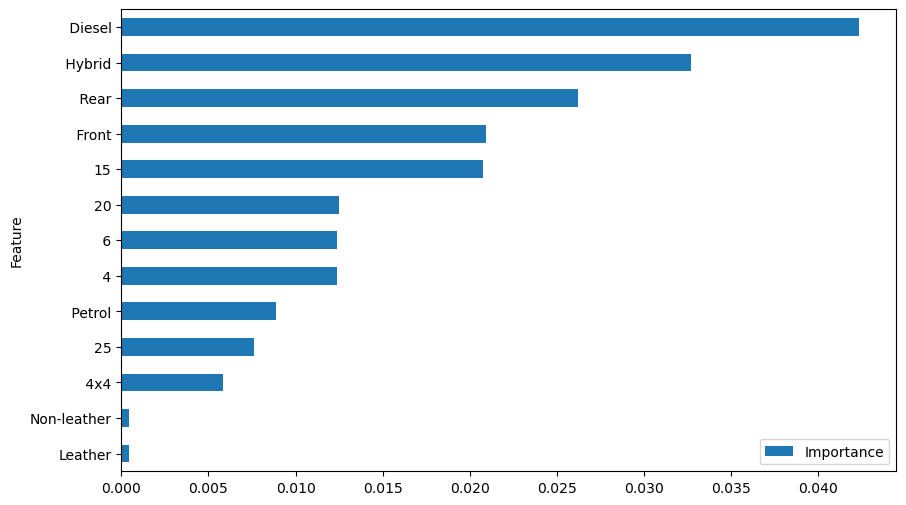

In [67]:
coefficients = clf.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train_clean.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

**6.4.1. Full Respondent Result**

In [68]:
summary = pd.DataFrame({'features': result.feature_names_in_.tolist() + ['constant'],
                                'weights': result.coef_[0].tolist() + result.intercept_.tolist()})
summary = summary.sort_values(by='weights', ascending=False)

summary

,features,weights
5,Diesel,0.042345
12,Rear,0.026178
0,15,0.020768
8,4,0.012403
3,Leather,0.000433
4,Non-leather,-0.000433
13,constant,-0.000594
10,4x4,-0.005841
2,25,-0.007617
7,Petrol,-0.008884


Recommendations:
- Price: 15.000 USD
- Fuel Type: Diesel
- Cylinders: 4
- Drive Wheel: Rear
- Leather interior: Leather

In [69]:
coeff = LogisticRegression.params.to_dict()
attrarray = {
'brand' : ['Sears','Goodyear','Goodrich'],
'Price' : ['Price50','Price60','Price70'],
'Miles' : ['Miles30K','Miles40K','Miles50K'],
'Side' : ['SideBlack','SideWhite']
}

part_worth_utility ={}
for attribute in attrarray.keys():
    print('\nAttribute:', attribute)
    temp_list = attrarray[attribute]
    for k in temp_list:
        part_worth_utility[k] =  coeff[k]
        print('       ',k, format(part_worth_utility[k], '.2f'))

AttributeError: type object 'LogisticRegression' has no attribute 'params'